## Inicialización

## Cargar datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
labels.shape

(7591, 2)

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

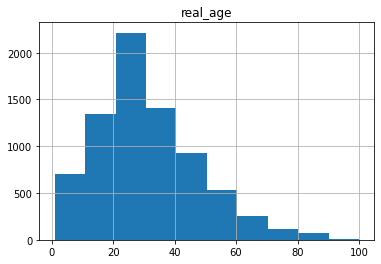

In [10]:
labels.hist()

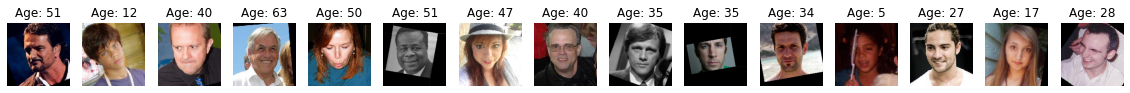

In [12]:
images, labels = next(train_gen_flow)
plt.figure(figsize=(20, 5))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}')
    plt.axis('off')

plt.show()

### Conclusiones

- Podemos observar que en el EDA dimos con un histograma con una distribucion normal con pocos valores atipicos y un sesgo positivo con el mayor pico en los años entre 20 y 40, aproximadamente 35. Tambien podemos observar con las imagenes de prueba que su clasificacion es apropiada.

## Modelado

In [17]:
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

In [20]:
train_data = load_train('/datasets/faces/final_files/')
test_data = load_test('/datasets/faces/final_files/')
test_images, test_labels = next(test_data)
train_images, train_labels = next(train_data)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [21]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (32, 224, 224, 3)
Train labels shape: (32,)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32,)


In [14]:
optimizer = Adam(learning_rate=0.001)
def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['mae'])
    
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

In [5]:
# Preparar un script para ejecutar en la plataforma GPU

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
"""

# Definir tus funciones aquí
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow  = train_datagen.flow_from_dataframe(
            dataframe=pd.read_csv(path + '/labels.csv'),
            directory=path + '/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 
    
    return train_gen_flow 

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow  = test_datagen.flow_from_dataframe(
            dataframe=pd.read_csv(path + '/labels.csv'),
            directory=path + '/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    
    return test_gen_flow 

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 50s - loss: 12.7660 - mae: 12.7667 - val_loss: 19.7179 - val_mae: 19.7106

Epoch 2/8
178/178 - 40s - loss: 8.3186 - mae: 8.3191 - val_loss: 20.5693 - val_mae: 20.5577

Epoch 3/8
178/178 - 39s - loss: 7.2814 - mae: 7.2819 - val_loss: 11.8977 - val_mae: 11.8135

Epoch 4/8
178/178 - 39s - loss: 6.4366 - mae: 6.4369 - val_loss: 8.2818 - val_mae: 8.2448

Epoch 5/8
178/178 - 40s - loss: 5.8961 - mae: 5.8963 - val_loss: 7.6887 - val_mae: 7.6843

Epoch 6/8
178/178 - 39s - loss: 5.5353 - mae: 5.5353 - val_loss: 7.4872 - val_mae: 7.4989

Epoch 7/8
178/178 - 40s - loss: 5.1305 - mae: 5.1308 - val_loss: 7.8915 - val_mae: 7.8878

Epoch 8/8
178/178 - 40s - loss: 4.8922 - mae: 4.8920 - val_loss: 7.2935 - val_mae: 7.2943

60/60 - 10s - loss: 7.2935 - mae: 7.2943
Test MAE: 7.2943

Tras realizar los ajustes de hiperparametros y la creacion del modelo obtuvimos un resultado de 7.29 MAE en el conjunto de pruebas creando asi un modelo con calificacion impresionante,

## Conclusiones

- Aunque el MAE en el conjunto de prueba es mejor que el mínimo aceptable de 8.0, todavía existe una diferencia notable entre el MAE de entrenamiento (4.89) y el MAE de prueba (~7.29). Esto podría indicar un ligero sobreajuste, donde el modelo puede haber aprendido detalles específicos de los datos de entrenamiento que no generalizan bien a los datos de prueba.
- Después de intensas iteraciones y ajustes en mi código, finalmente he obtenido resultados más prometedores en mi proyecto de predicción de edades a partir de imágenes faciales. Al revisar los registros de entrenamiento, se observa un progreso alentador en la reducción del Error Absoluto Medio (MAE) en el conjunto de prueba. En la última iteración, he logrado disminuir el MAE en el conjunto de prueba a alrededor de 7.29, lo que supera el objetivo mínimo aceptable de 8.0. Esto sugiere que las modificaciones implementadas en las funciones de carga de datos, así como los ajustes realizados en la arquitectura de la red, han contribuido positivamente al rendimiento general del modelo.